###  1) Introduction
This project dataset contains whether a customer converted or not by viewing old home page(control group) vs new home page (treatment group) in a e-commerce website.
Goals for this project are:

1)help the company understand if they should implement the new page or keep the old page

2)Do company need to run the experiment longer to make their decision.

### 2) Import pacakges

In [118]:
# data manipulation
import numpy as np 
import pandas as pd 

#data visualization
import matplotlib.pyplot as plt
import seaborn as sns 

#random function
import random
import math
random.seed(20) 
import statsmodels.api as sm

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

### 3) Load Data and Preview data

In [4]:
df = pd.read_csv("ab_test.csv")
df.head(10)

,id,time,con_treat,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1
5,936923,20:49.1,control,old_page,0
6,679687,26:46.9,treatment,new_page,1
7,719014,48:29.5,control,old_page,0
8,817355,58:09.0,treatment,new_page,1
9,839785,11:06.6,treatment,new_page,1


In [5]:
#inspecting data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         294478 non-null  int64 
 1   time       294478 non-null  object
 2   con_treat  294478 non-null  object
 3   page       294478 non-null  object
 4   converted  294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [6]:
#check null values, no null values
df.isnull().sum()

id           0
time         0
con_treat    0
page         0
converted    0
dtype: int64

### 4) EDA and Summary Stats

In [9]:
#numer of rows and unique users
print(f'Number of rows: {df.shape[0]}')
print(f'Number of unique users: {df.id.nunique()}')

Number of rows: 294478
Number of unique users: 290584


In [13]:
# A/B Groups & Target Summary Stats
df.groupby("page").converted.agg(["count","mean", "std"])

,count,mean,std
page,,,
new_page,147239,0.118841,0.323602
old_page,147239,0.120478,0.325520


In [14]:
# A/B Groups & Target Summary Stats
df.groupby("con_treat").converted.agg(["count","mean", "std"])

,count,mean,std
con_treat,,,
control,147202,0.120399,0.325429
treatment,147276,0.118920,0.323695


###### Number of people seeing old_page and new_page is same; but size between control and treatment group has slightly difference---which needs further analysis

In [18]:
# lets see treatment rows with old website page
df[(df["con_treat"] == "treatment") & (df["page"] == "old_page")]

,id,time,con_treat,page,converted
308,857184,34:59.8,treatment,old_page,0
327,686623,26:40.7,treatment,old_page,0
357,856078,29:30.4,treatment,old_page,0
685,666385,11:54.8,treatment,old_page,0
713,748761,47:44.4,treatment,old_page,0
...,...,...,...,...,...
293773,688144,34:50.5,treatment,old_page,1
293817,876037,15:09.0,treatment,old_page,1
293917,738357,37:55.7,treatment,old_page,0
294014,813406,25:33.2,treatment,old_page,0


##### check all mismatch records 

In [19]:
mismatch = df[(df["con_treat"] == "treatment") & (df["page"] == "old_page")
               |(df["con_treat"] == "control") & (df["page"] == "new_page")]

n_mismatch = mismatch.shape[0]

percent_mismatch = round(n_mismatch / len(df) * 100, 2)
print(f'Number of mismatched rows: {n_mismatch} rows')
print(f'Percent of mismatched rows: {percent_mismatch} percent')

Number of mismatched rows: 3893 rows
Percent of mismatched rows: 1.32 percent


##### Those 3893 rows are incorrect: Treatment with old page or Control with new page; Needs to be excluded from further analysis

In [21]:
df = df[(df["con_treat"] == "treatment") & (df["page"] == "new_page")
        |(df["con_treat"] == "control") & (df["page"] == "old_page")]

len(df)

290585

In [23]:
#check again numer of rows and unique users----remove duplicate userid
print(f'Number of rows: {df.shape[0]}')
print(f'Number of unique users: {df.id.nunique()}')

Number of rows: 290585
Number of unique users: 290584


In [24]:
#drop the duplicated userid
df = df.drop_duplicates("id") 

### 5) Calculate Probability

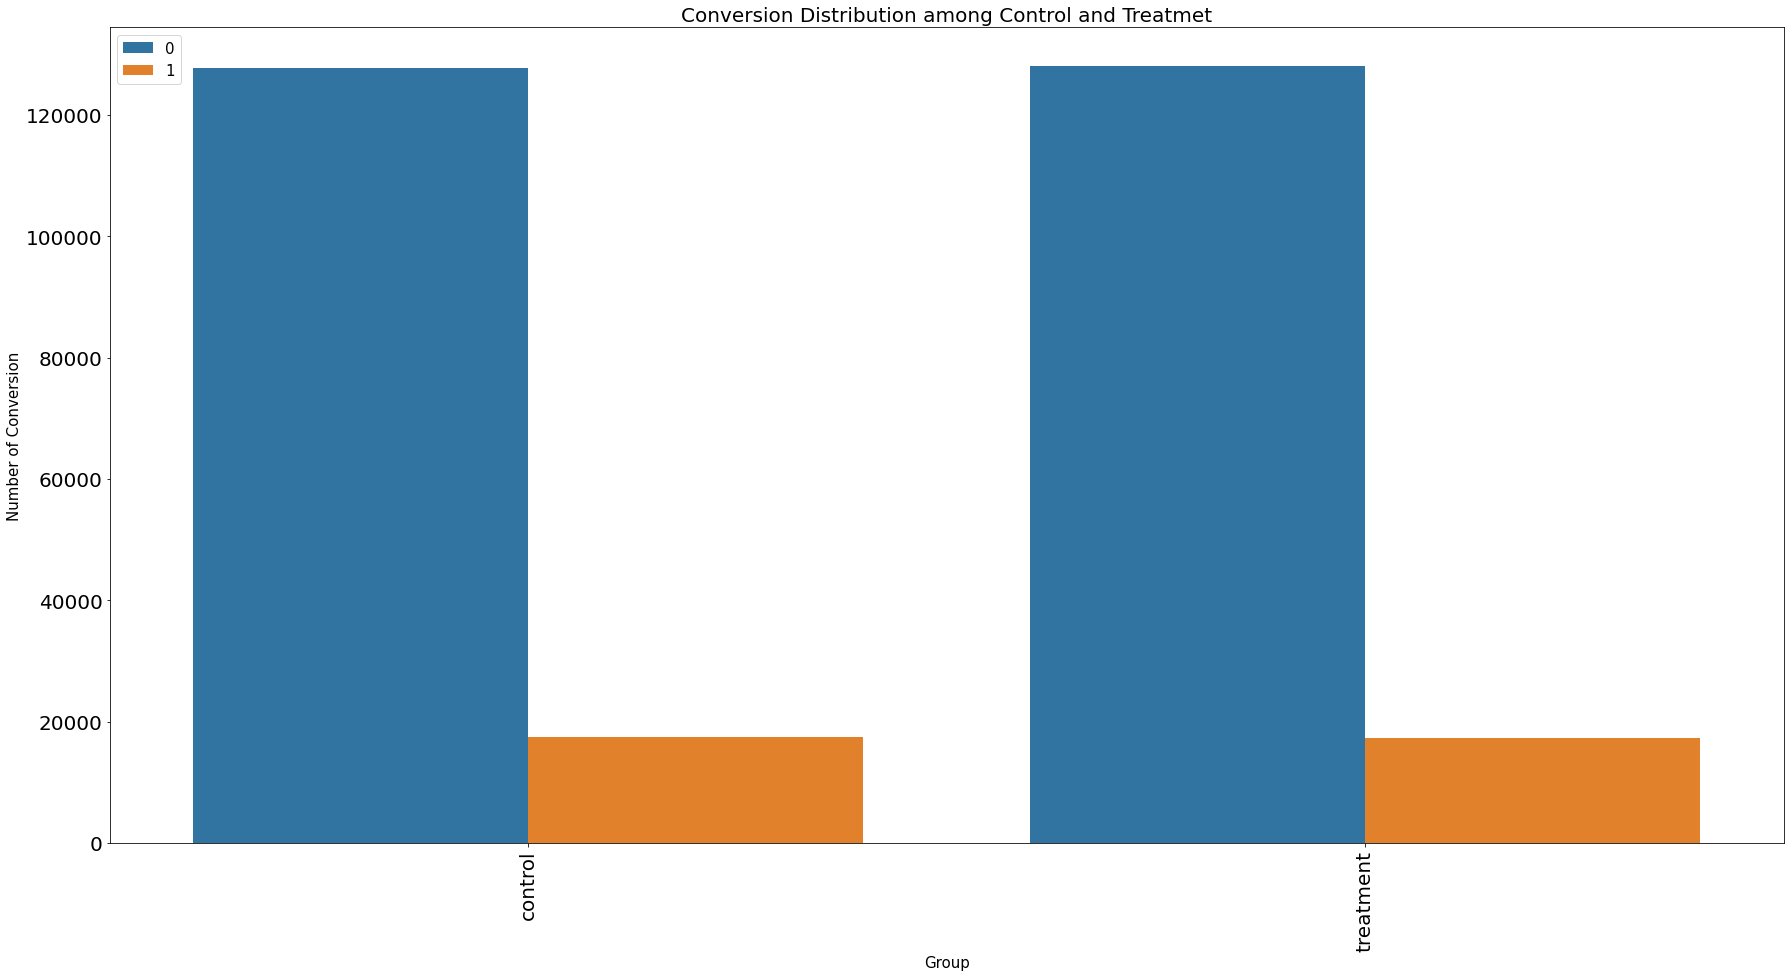

In [33]:
# Visualize control and treatment conversion rate
plt.figure(figsize=(30,15))
sns.barplot(x="con_treat", y='id' ,hue="converted", 
            data=df.groupby(['con_treat','converted']).agg({'id':'count'}).reset_index())
plt.xlabel('Group', fontsize = 15)
plt.ylabel('Number of Conversion', fontsize = 15)
plt.title("Conversion Distribution among Control and Treatmet", fontsize = 20)
plt.xticks(rotation = 90)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.legend(loc=2, prop={'size': 15})
plt.show()

In [35]:
#in the control group, what is the probability of conversion
#in the treatment group, what is the probability of conversion
df.id = df.id.astype(str)
df.groupby("con_treat").mean() * 100

,converted
con_treat,
control,12.038630
treatment,11.880807


In [41]:
# probability of a customer assigned to control or treatment group
pd.DataFrame(df.page.value_counts(normalize = True) * 100)

,page
new_page,50.006194
old_page,49.993806


##### Those are some observations after running summary statistics and probabilities:
 1) The probability that an individual received the new page is around 50%
 
 2) Given that an individual was in the control group, the probability they converted is 12.04%
 
 3) Given that an individual was in the treatment group, the probability they converted is 11.88%
 
 4) There is almost difference of conversion rate between treatment and control group

### 6) Hypothesis and A/B testing

 Assuming Type I error rate of 5%

𝐻0: 𝑝𝑜𝑙𝑑 - 𝑝𝑛𝑒𝑤 = 0

𝐻1: 𝑝𝑜𝑙𝑑 - 𝑝𝑛𝑒𝑤 ≠ 0

In [43]:
# Visualize sampling distribution of (Avg.Pold - Avg.Pnew) difference  
avg_diff = []
size = df.shape[0]
for i in range(10000):
    sample = df.sample(size, replace = True)
    control_mean = sample[sample["con_treat"] == "control"]["converted"].mean()
    treat_mean = sample[sample["con_treat"] == "treatment"]["converted"].mean()
    avg_diff.append(treat_mean - control_mean)

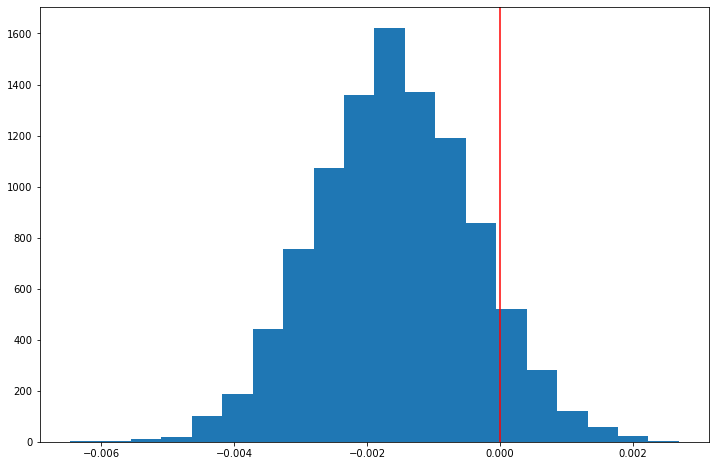

In [67]:
# Plotting the sampling distribution 
plt.figure(figsize = (12,8))
plt.hist(avg_diff, bins = 20)
plt.axvline(0, c='red')
plt.show()

In [53]:
# Simulate distribution under the null hypothesis
avg_diff = np.array(avg_diff)
null_vals = np.random.normal(0, avg_diff.std(), avg_diff.size)

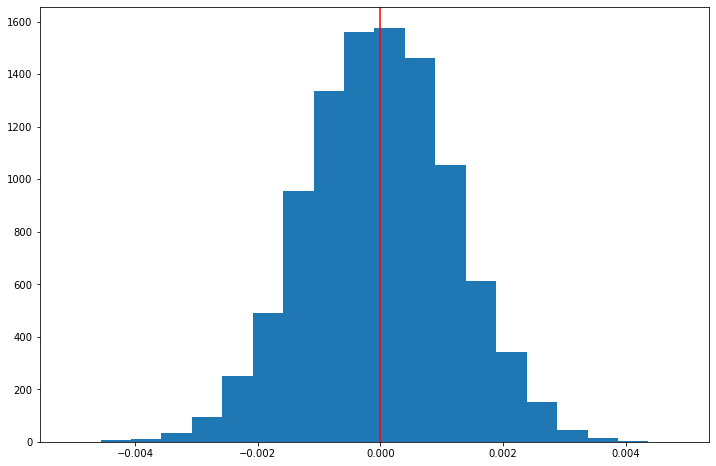

In [60]:
# Plotting the null hypo distribution 
plt.figure(figsize = (12,8))
plt.hist(null_vals, bins = 20)
plt.axvline(0, c='red')
plt.show()

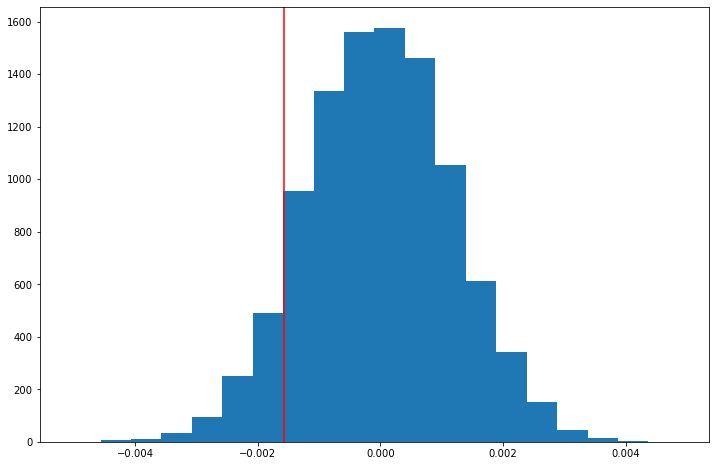

In [68]:
# Plot observed difference  with the null distibution
control_mean = df[df["con_treat"] == "control"]["converted"].mean()
treat_mean = df[df["con_treat"] == "treatment"]["converted"].mean()
obs_diff = treat_mean - control_mean

plt.figure(figsize = (12,8))
plt.hist(null_vals, bins = 20)
plt.axvline(obs_diff, c='red')
plt.show()

In [56]:
# calculating the p value 
(null_vals > obs_diff).mean()

0.9101

The p_value (0.9) is greater than alpha, therefore we fail to reject the null.

Conclusion: there is no significant impact for the new page.

### 7) Check Z-score and P-value

##### check z-score for alpha=0.05

In [70]:
from scipy.stats import norm
# Inputs:
#   The desired alpha for a two-tailed test
# Returns: The z-critical value
def get_z_star(alpha):
    return norm.ppf((1-alpha/2))

In [71]:
# get z_critical value when alpha = 0.05
get_z_star(0.05)

1.959963984540054

In [98]:
convert_old = df[(df["converted"] == 1) & (df["page"] == "old_page")]['id'].nunique()
convert_new = df[(df["converted"] == 1) & (df["page"] == "new_page")]['id'].nunique()
n_old = df[df["page"] == "old_page"]['id'].nunique()
n_new = df[df["page"] == "new_page"]['id'].nunique()
print(f'Numer of users Converted old page : {convert_old}')
print(f'Numer of users Converted new page : {convert_new}')
print(f'Numer of users Seeing old page : {n_old}')
print(f'Numer of users Seeing new page : {n_new}')

Numer of users Converted old page : 17489
Numer of users Converted new page : 17264
Numer of users Seeing old page : 145274
Numer of users Seeing new page : 145310


##### Check confidence interval and stastical significance

In [108]:
p_pool=(convert_old+convert_new)/(n_old+n_new)
SE_pool=math.sqrt(p_pool*(1-p_pool)*(1/n_old+1/n_new))
m=SE_pool*1.96
d_hat=convert_new/n_new-convert_old/n_old
print("Confidence Interval:[{},{}]".format(d_hat-m,d_hat+m))
print("Observed:",d_hat)
print ("Statistically significant:", d_hat+m<0 or d_hat-m>0 ,",  Confidence Interval does include 0")

Confidence Interval:[-0.00393790891517839,0.0007814309444672761]
Observed: -0.0015782389853555567
Statistically significant: False ,  Confidence Interval does include 0


From calculated confidence Interval, we know that difference between control group and treatment group is not statistically significant. Next step, we can look at p_value to double-confirm.

In [121]:
#Compute test statistic and p-value
z_score, p_value = sm.stats.proportions_ztest(
    np.array([convert_new,convert_old]),np.array([n_new,n_old]), alternative = 'two-sided')
print(p_value)

0.18988337448195103


P-value is 0.19>0.05--> Fail to reject null hypothesis, which indicates Pold-Pnew = 0; New website page didn't positively convert more customers.

### 8) Summary:
we conducted a  A/B testing using 2  methods:

1) Sampling distribution

2) Two-tailed Z test
Both methods resulted in the same conclusion:

new landing page has no impact on change coversion rate of customers

### 9) Look at Duration for this A/B Testing

In [122]:
print('The starting time of this A/B testing is {}'.format(min(df['time'])))
print('The ending time of this A/B testing is {}'.format(max(df['time'])))

The starting time of this A/B testing is 00:00.0
The ending time of this A/B testing is 59:59.9


We could see this A/B testing conducted for 60 hrs.
To get a representative sample and for  data to be accurate, experts recommend that you run your test for a minimum of one to two week, Running 60 hrs (less than 3 days) usually got biased result because weekend traffic is different from weekdays.